In [1]:
import pandas as pd
import numpy as np
import warnings
import math
import json
import glob
import csv
import re
import os

from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from matplotlib import cm
%config InlineBackend.figure_formats = ['svg']

In [12]:
df = pd.DataFrame(data={'a': [1,2], 'b': [3,4]})
df['c'] = 10
df

,a,b,c
0,1,3,10
1,2,4,10


In [2]:
col = 'mean_rew'

def read_paths(paths, names, sigma=2):
    smoothing = lambda x: gaussian_filter1d(x, sigma=sigma)
    data = []
    for path, name in zip(paths, names):
        df = pd.read_csv(os.path.join(path, "progress.csv"))
        df['name'] = name
        df[col] = smoothing(df[col])
        data.append(df)
    return pd.concat(data)

In [57]:
dfs = read_paths(["../runs/2019_07_08__12_25_59__walker-nomirror/1", "../runs/2019_07_08__12_23_28__walker-mirror/1", "../runs/2019_07_08__12_25_59__walker-nomirror/1", "../runs/2019_07_08__12_23_28__walker-mirror/1"], ["nomirror", "mirror"])
grp = dfs.groupby(["iter", "name"], as_index=False)
means = grp.mean()
means['mean_rew__max'] = grp.max()['mean_rew']
means[:5]
df[[col] + ['name', row]].groupby(by=['name', row]).std(numeric_only=True)[col]

UnsupportedFunctionCall: numpy operations are not valid with groupby. Use .groupby(...).std() instead

In [3]:
row = 'total_num_steps'

def aggregate(df, by=['name', row], stats_for=[col]):
    grouped = df.groupby(by=by, as_index=False)
    df = grouped.mean()
    for col in stats_for:
        df[col] = df[col]
        df[col + '__min'] = grouped.min()[col]
        df[col + '__max'] = grouped.max()[col]
#         df[col + '__std'] = grouped.std()[col]
#         df[col + '__std'] = grouped.std(numeric_only=True)[col]
#         df[col + '__std'] = df[[col]+by].groupby(by).std()[col].values
    return df

In [71]:
df = aggregate(dfs)

In [72]:
df[:5]

,name,total_num_steps,iter,fps,entropy,value_loss,action_loss,mean_rew,median_rew,min_rew,max_rew,mean_rew__min,mean_rew__max
0,mirror,49984,1,442,8.540653,1.330017,-0.009683,12.258536,10.826916,3.335135,14.941954,12.258536,12.258536
1,mirror,99968,2,439,8.319120,1.027526,-0.028749,13.208956,10.595225,8.016440,14.769488,13.208956,13.208956
2,mirror,149952,3,440,8.112177,1.422546,-0.038757,15.247100,12.669864,8.450256,19.327199,15.247100,15.247100
3,mirror,199936,4,440,7.932234,2.323006,-0.034567,18.558682,13.915691,8.638498,25.212625,18.558682,18.558682
4,mirror,249920,5,440,7.787744,4.438533,-0.029666,23.248457,16.968110,8.936371,47.911932,23.248457,23.248457


RuntimeError: ("array type dtype('O') not supported", 'occurred at index name')

/home/farzad/devel/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


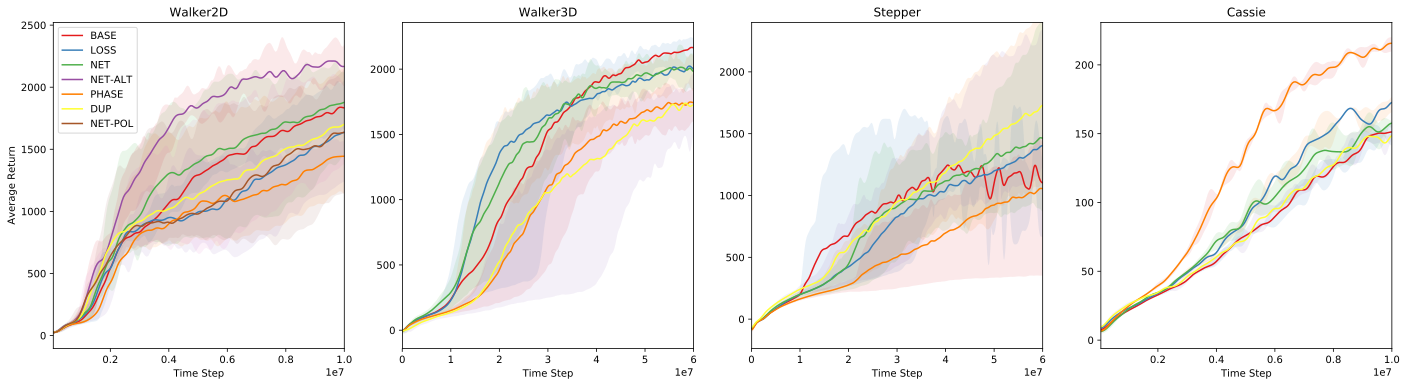

In [14]:
experiments = {
    'Walker2D': {
        'dirs': glob.glob("../experiments/Walker2D/*/*/"),
        'regex': "w2.*_([^-\/]*)",
        'smoothing': 2,
    },
    'Walker3D': {
        'dirs': glob.glob("../experiments/Walker3D/*/*/"),
        'regex': "w3.*_([^\/]*)",
        'smoothing': 7,
    },
    'Stepper': {
        'dirs': glob.glob("../experiments/Stepper/*/*/"),
        'regex': "stepper.*_([^\/]*)",
        'smoothing': 8,
        'max_y': 2400,
    },
    'Cassie': {
        'dirs': glob.glob("../experiments/Cassie/*/"),
        'regex': "cassie-([^-\/]*)",
        'smoothing': 3,
    },
}

colors = cm.Set1.colors

method_map = {
    'base': 'BASE',
    'loss': 'LOSS',
    'net': 'NET',
    'phase': 'PHASE',
    'traj': 'DUP',
    'net2': 'NET-ALT',
    'vnet': 'NET-POL',
}

name_to_color = {}
def get_color(name):
    if name not in name_to_color:
        name_to_color[name] = colors[len(name_to_color)]
    return name_to_color[name]

fig, axs = plt.subplots(1, len(experiments), figsize=(6 * len(experiments), 6))

for i, (exp_name, exp) in enumerate(experiments.items()):
    dirs = exp['dirs']
    names = [re.findall(exp['regex'], path)[0] for path in dirs]
    df = aggregate(read_paths(dirs, names, sigma=exp['smoothing']))
    
    ax = axs[i]
    ax.set_title(exp_name)
    for key, grp in df.groupby(['name']):
        ax = grp.plot(ax=ax, kind='line', x=row, y='mean_rew', c=get_color(key), label=method_map[key])
        ax.fill_between(grp[row], grp[col + '__min'], grp[col + '__max'], alpha=0.1)
#         ax.fill_between(grp[row], grp[col] - grp[col + '__std'], grp[col] + grp[col + '__std'], alpha=0.1)
    
    if 'max_y' in exp:
        ax.set_ylim(ax.get_ylim()[0], exp['max_y'])
    
    if i != 0:
        ax.get_legend().remove()
    ax.set_xlabel('Time Step')

_ = axs[0].set_ylabel('Average Return')
fig.savefig('LearningCurves.pdf', bbox_inches="tight")

In [7]:
ax.get_ylim()

(-6.017047412560178, 230.87125696488351)